# Dagger Workshop - JuliaCon 2024

![Dagger Logo](logo.jpg)

![QR Code](qr.png)

### Presenters:
- Julian Samaroo (MIT JuliaLab)
- Prof. Przemyslaw Szufel (SGH Warsaw)

### Assisted by:
- Dr. Rabab Alomairy (MIT JuliaLab)

## First, some setup!

Let's get code loaded and make sure your Julia and Jupyter session is setup correctly! This will load a bunch of packages, so maybe start this while you listen to us talk :)

In [1]:
# Make sure to always load this first when you restart the notebook!
include("setup.jl")

  Activating project at `/mnt/alpine/home/jpsamaroo/docs/JuliaCon/2024`
Precompiling project...
           ✗ Metal → BFloat16sExt
  0 dependencies successfully precompiled in 4 seconds. 437 already precompiled.
[ Info: Your Julia is running with 6 threads
[ Info: Starting up 2 multi-threaded workers...


      From worker 2:	  Activating project at `/mnt/alpine/home/jpsamaroo/docs/JuliaCon/2024`
      From worker 3:	  Activating project at `/mnt/alpine/home/jpsamaroo/docs/JuliaCon/2024`


[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (2))


### Why have this workshop?

- Users want easy parallelism, library authors want composable parallelism
- It's easy to do multithreading *OR* distributed *OR* GPU - why not all 3 at once?
- Dagger can provide all of this, but how can we use it to achieve our goals?

### What is Dagger?

- Unified task interface for multithreading, distributed, and GPU programming
- Distributed high-performance scheduler using machine learning
- APIs for programming with arrays, tables, and graphs
- Out-of-core and checkpointing support enables solving large problems

### What difficult problems does Dagger solve?

- Cross-task dependency/synchronization management
- Abstracting computation across servers, threads, and GPUs
- Dynamic workload balancing
- Automating data transfers, while hiding latency
- Automatic GPU utilization and data conversion

## Workshop Overview

Part 1:
- Intro to Task-based computing, Multithreading, Distributed, and Julia's parallelism utilities
- Intro to Dagger's Task-Based computing
- DArrays (Dagger's Distributed Arrays)
- Datadeps (Dagger's Data Dependencies system)

Short break (~15 mins)

Part 2:
- Tabular analysis with DataFrames and DTables
- DGraphs (Dagger's Graphs interface)
- Dagger Streaming

# Tasks with Dagger

## What is a Dagger "Task"?

In Dagger, our bread and butter are "tasks", which are basically just function calls that happen asynchronously (in the background). Tasks are constructed with `Dagger.@spawn`, which takes any number of arguments, a function to call with those arguments, and produce a result:

In [2]:
t = Dagger.@spawn 1+2
@show t
fetch(t)

t = DTask (running)


3

That `Dagger.@spawn` operation (a Julia macro) wraps the `+` function and the arguments `1` and `2` in a Dagger task, and executes it asynchronously. You'll notice that it's a `DTask` object, which means "Dagger task".

Another thing to notice is that just like other "async/await"-style implementations (like in Rust or JavaScript), we need to call the `fetch` function to wait for the task to finish and then get its result. If you don't call `fetch`, that's ok - it'll still run in the background, and you can `fetch` it whenever you're ready to see the result.

#### Function Chaining

Like you might expect when working with functions, one task can use the result of another task as its input:

In [3]:
a = Dagger.@spawn 1+2
fetch(Dagger.@spawn exp(a))

20.085536923187668

Dagger will always execute your tasks in the order that you would expect, from how one task depends on another (in the form of a "Directed Acyclic Graph", or "DAG", hence the name "Dagger"!)

#### `@spawn` parsing

Do note that `@spawn` only applies to the outermost function call; any other function calls within the expression are *evaluated immediately*, and then passed into the outermost function call as arguments:

In [4]:
@show fetch(Dagger.@spawn Dagger.in_task());
@show fetch(Dagger.@spawn Bool(Dagger.in_task()));

fetch(#= In[4]:1 =# Dagger.@spawn(Dagger.in_task())) = true
fetch(#= In[4]:2 =# Dagger.@spawn(Bool(Dagger.in_task()))) = false


Here, `Dagger.in_task()` returns `true` when called within a Dagger task, and `false` otherwise. So the latter `@spawn` call is evaluating `Dagger.in_task` *immediately* (outside of the Dagger task we're creating), and then just calling `Bool` on the result, within the Dagger task. Bottom line - make sure the outermost function call is the one you want Dagger to execute!

#### Errors and Exceptions

If you do something that causes an error within a task, you'll get that error reported during `fetch` (but not during `wait`, that just waits for the task to finish for *any* reason):

In [5]:
t = Dagger.@spawn error("Oops!")
wait(t)
println("Task finished!")
fetch(t)
println("We'll never get here since `fetch` will throw an error")

Task finished!


LoadError: DTaskFailedException:
  Root Exception Type: ErrorException
  Root Exception:
Oops!
Stacktrace:
 [1] [0m[1merror[22m[0m[1m([22m[90ms[39m::[0mString[0m[1m)[22m
[90m   @[39m [90mBase[39m [90m./[39m[90m[4merror.jl:35[24m[39m
 [2] [0m[1m#invokelatest#2[22m
[90m   @[39m [90m./[39m[90m[4messentials.jl:1031[24m[39m[90m [inlined][39m
 [3] [0m[1minvokelatest[22m
[90m   @[39m [90m./[39m[90m[4messentials.jl:1028[24m[39m[90m [inlined][39m
 [4] [0m[1m(::Dagger.var"#41#43"{@Kwargs{}, typeof(error), Tuple{String}, Base.RefValue{Any}, @NamedTuple{sch_uid::UInt64, sch_handle::Dagger.Sch.SchedulerHandle, processor::Dagger.ThreadProc, task_spec::Vector{Any}}})[22m[0m[1m([22m[0m[1m)[22m
[90m   @[39m [35mDagger[39m [90m~/.julia/packages/Dagger/crCxz/src/[39m[90m[4mthreadproc.jl:20[24m[39m
Stacktrace:
  [1] [0m[1mwait[22m[0m[1m([22m[90mt[39m::[0mTask[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m./[39m[90m[4mtask.jl:363[24m[39m
  [2] [0m[1mfetch[22m
[90m    @[39m [90m./[39m[90m[4mtask.jl:383[24m[39m[90m [inlined][39m
  [3] [0m[1mexecute![22m[0m[1m([22m::[0mDagger.ThreadProc, ::[0mAny, ::[0mAny, ::[0mVararg[90m{Any}[39m; [90mkwargs[39m...[0m[1m)[22m
[90m    @[39m [35mDagger[39m [90m~/.julia/packages/Dagger/crCxz/src/[39m[90m[4mthreadproc.jl:26[24m[39m
  [4] [0m[1mexecute![22m[0m[1m([22m::[0mDagger.ThreadProc, ::[0mAny, ::[0mAny, ::[0mVararg[90m{Any}[39m[0m[1m)[22m
[90m    @[39m [35mDagger[39m [90m~/.julia/packages/Dagger/crCxz/src/[39m[90m[4mthreadproc.jl:13[24m[39m
  [5] [0m[1m#169[22m
[90m    @[39m [90m~/.julia/packages/Dagger/crCxz/src/sch/[39m[90m[4mSch.jl:1659[24m[39m[90m [inlined][39m
  [6] [0m[1m#21[22m
[90m    @[39m [90m~/.julia/packages/Dagger/crCxz/src/[39m[90m[4moptions.jl:18[24m[39m[90m [inlined][39m
  [7] [0m[1mwith[22m[0m[1m([22m::[0mDagger.var"#21#22"[90m{Dagger.Sch.var"#169#177"{Dagger.ThreadProc, Vector{Pair{Symbol, Any}}, Vector{Any}}}[39m, ::[0mPair[90m{Base.ScopedValues.ScopedValue{NamedTuple}, @NamedTuple{}}[39m[0m[1m)[22m
[90m    @[39m [90mBase.ScopedValues[39m [90m./[39m[90m[4mscopedvalues.jl:267[24m[39m
  [8] [0m[1mwith_options[22m[0m[1m([22m[90mf[39m::[0mDagger.Sch.var"#169#177"[90m{Dagger.ThreadProc, Vector{Pair{Symbol, Any}}, Vector{Any}}[39m, [90moptions[39m::[0m@NamedTuple[90m{}[39m[0m[1m)[22m
[90m    @[39m [35mDagger[39m [90m~/.julia/packages/Dagger/crCxz/src/[39m[90m[4moptions.jl:17[24m[39m
  [9] [0m[1mdo_task[22m[0m[1m([22m[90mto_proc[39m::[0mDagger.ThreadProc, [90mtask_desc[39m::[0mVector[90m{Any}[39m[0m[1m)[22m
[90m    @[39m [35mDagger.Sch[39m [90m~/.julia/packages/Dagger/crCxz/src/sch/[39m[90m[4mSch.jl:1657[24m[39m
 [10] [0m[1m(::Dagger.Sch.var"#145#153"{UInt64, UInt32, Dagger.Sch.ProcessorInternalState, RemoteChannel{Channel{Any}}, Dagger.ThreadProc})[22m[0m[1m([22m[0m[1m)[22m
[90m    @[39m [35mDagger.Sch[39m [90m~/.julia/packages/Dagger/crCxz/src/sch/[39m[90m[4mSch.jl:1333[24m[39m
  This Task:  DTask(id=7, error(Oops!))

The error is a bit verbose, however, that verbosity comes in handy when a debugging a task failing a bit further upstream from that task that was fetched:

In [6]:
t1 = Dagger.@spawn error("Oops!")
t2 = Dagger.@spawn t1+2
t3 = Dagger.@spawn t2*2
fetch(t3)

LoadError: DTaskFailedException:
  Root Exception Type: ErrorException
  Root Exception:
Oops!
Stacktrace:
 [1] [0m[1merror[22m
[90m   @[39m [90m./[39m[90m[4merror.jl:35[24m[39m
 [2] [0m[1m#invokelatest#2[22m
[90m   @[39m [90m./[39m[90m[4messentials.jl:1031[24m[39m[90m [inlined][39m
 [3] [0m[1minvokelatest[22m
[90m   @[39m [90m./[39m[90m[4messentials.jl:1028[24m[39m[90m [inlined][39m
 [4] [0m[1m#41[22m
[90m   @[39m [90m~/.julia/packages/Dagger/crCxz/src/[39m[90m[4mthreadproc.jl:20[24m[39m
Stacktrace:
  [1] [0m[1mwait[22m
[90m    @[39m [90m./[39m[90m[4mtask.jl:363[24m[39m
  [2] [0m[1mfetch[22m
[90m    @[39m [90m./[39m[90m[4mtask.jl:383[24m[39m[90m [inlined][39m
  [3] [0m[1m#execute!#40[22m
[90m    @[39m [90m~/.julia/packages/Dagger/crCxz/src/[39m[90m[4mthreadproc.jl:26[24m[39m
  [4] [0m[1mexecute![22m
[90m    @[39m [90m~/.julia/packages/Dagger/crCxz/src/[39m[90m[4mthreadproc.jl:13[24m[39m
  [5] [0m[1m#169[22m
[90m    @[39m [90m~/.julia/packages/Dagger/crCxz/src/sch/[39m[90m[4mSch.jl:1659[24m[39m[90m [inlined][39m
  [6] [0m[1m#21[22m
[90m    @[39m [90m~/.julia/packages/Dagger/crCxz/src/[39m[90m[4moptions.jl:18[24m[39m[90m [inlined][39m
  [7] [0m[1mwith[22m
[90m    @[39m [90m./[39m[90m[4mscopedvalues.jl:267[24m[39m
  [8] [0m[1mwith_options[22m
[90m    @[39m [90m~/.julia/packages/Dagger/crCxz/src/[39m[90m[4moptions.jl:17[24m[39m
  [9] [0m[1mdo_task[22m
[90m    @[39m [90m~/.julia/packages/Dagger/crCxz/src/sch/[39m[90m[4mSch.jl:1657[24m[39m
 [10] [0m[1m#145[22m
[90m    @[39m [90m~/.julia/packages/Dagger/crCxz/src/sch/[39m[90m[4mSch.jl:1333[24m[39m
  Root Task:  DTask(id=8, error(Oops!))
  Inner Task: DTask(id=10, *(Thunk[9](+, ...), 2))
  This Task:  DTask(id=10, *(Thunk[9](+, ...), 2))

The `DTaskFailedException` shows the chain of tasks that propagated the "root error" to this task, which can be really handy in tracing down the source of an error in a more complicated program written with Dagger.

#### Multiple Dependencies and Parallelism

It's easy to construct your program from a bunch of tasks that depend on each other (just like with regular functions):

In [7]:
x = rand(5000)
a = Dagger.@spawn x .+ 1
b = Dagger.@spawn a .* 2
c = Dagger.@spawn a ./ 2
d = Dagger.@spawn b .- c
fetch(d)

50000-element Vector{Float64}:
 1.7042901607383931
 2.9540831763995956
 1.9392591027449821
 1.831299050919448
 2.805403322949994
 1.6136379538128793
 2.88955249346854
 2.1618357338445593
 2.8129743526224757
 2.354511346119697
 2.3413636761938346
 2.858754805491105
 2.741104494181301
 ⋮
 1.818239321916773
 1.8903381584843886
 1.695269732534667
 2.510357693514629
 2.88030999842245
 2.7588493543222086
 2.6210967791970474
 2.6111366342188207
 2.74912488492464
 2.665460390706378
 2.8200668679803873
 1.5663039767651679

In the above code, Dagger can execute `b` and `c` in parallel, since they don't depend on each other (`b` depends on `a`, and `c` depends on `a`, but `b` and `c` otherwise don't depend on each other).

You might think, "It would be really nice if `b` and `c` would run at the same time". Conveniently, you don't have to tell Dagger to do this - it's automatic! Dagger will automatically parallelize computations like this. We can see how Dagger's scheduler parallelizes tasks by using Dagger's visualization capabilities:

Task DAG:


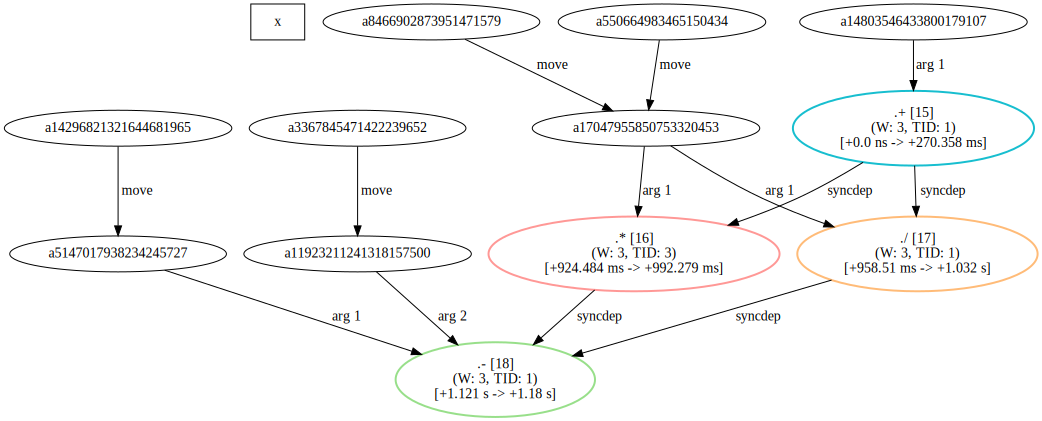

Execution Gantt chart:


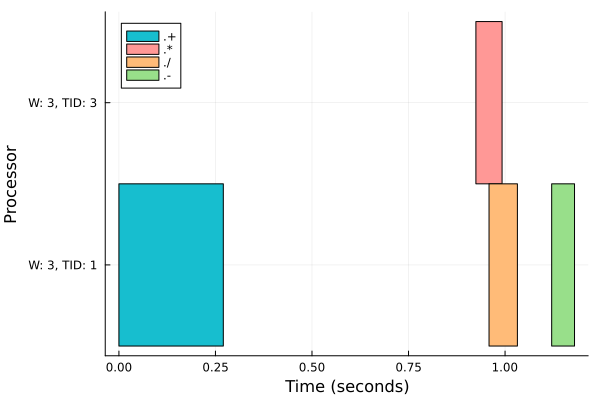

In [8]:
workshop_plots() do # `workshop_plots` is a convenience function in utils.jl, not provided by Dagger
    x = rand(5000)
    Dagger.logs_annotate!(x, "x") # this utility gives Dagger a nice name to associate with this variable in the DAG graph
    a = Dagger.@spawn x .+ 1
    b = Dagger.@spawn a .* 2
    c = Dagger.@spawn a ./ 2
    d = Dagger.@spawn b .- c
end;

Now we can see Dagger's DAG for the above 4 tasks, as well as the timeline of execution based on how Dagger scheduled these tasks. There's not a *ton* of parallelism to see here (there is too much overhead for the little bit of parallelism between `b` and `c` to be easily apparent), but it's pretty easy to see parallelism with a slightly contrived example:

Execution Gantt chart:


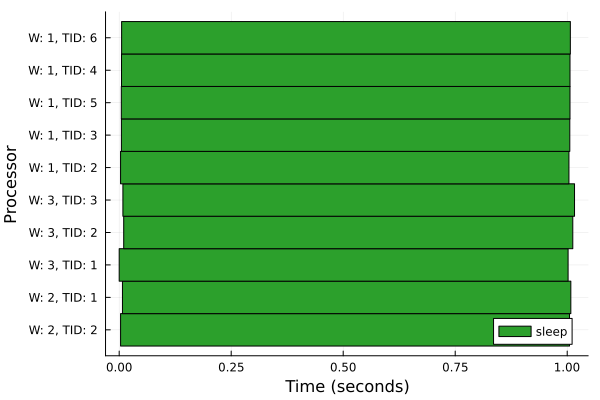

In [10]:
workshop_plots(;dag=false) do # We don't too much care about the DAG, as all tasks are independent of each other
    for i in 1:10
        Dagger.@spawn sleep(1)
    end
end;

In this example, since all 10 tasks don't depend on each other, they can run fully independently, and so Dagger will run a full batch of `sleep` calls in parallel at a time. If you want to let Dagger execute all of these tasks at once (because it's a good idea to do so - they don't take up any resources), you can tell Dagger that their "occupancy" of the task is 0 (basically, it doesn't spend any measurable amount of time doing anything expect sleeping):

Execution Gantt chart:


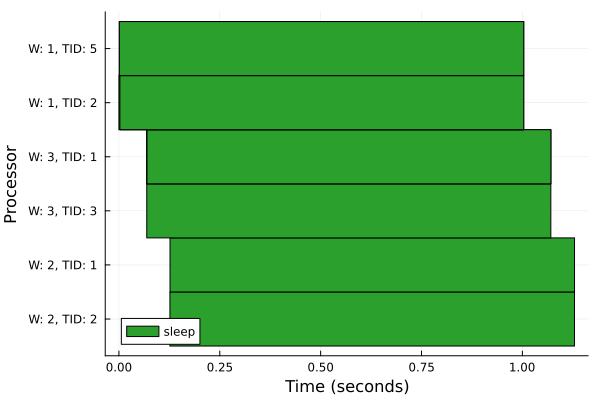

In [11]:
workshop_plots(;dag=false) do # We don't too much care about the DAG, as all tasks are independent of each other
    for i in 1:10
        # Slightly ugly syntax - this will eventually just be `occupancy=0`
        Dagger.@spawn occupancy=Dict(Dagger.ThreadProc=>0) sleep(1)
    end
end;

#### Example 1: Stock Prices

Let's pause for a moment to see an example of stock price estimation using Dagger.

#### Execution Control with Scopes

You'll notice the "W: 1, TID: 3" notation above - this means "worker 1, thread 3", which is indicating where each task is running. You might know that Julia supports both multithreading (code running simultanously on different CPU threads) and distributed/multiprocessing (code running simultaneously on different servers/processes) - Dagger supports both multithreading and distributed, and will in fact use both of them at the same time! You don't tell Dagger to do this, or do any opt-in; it's all automatic and done by default.

Of course, you might think, "This won't always be the best idea! Maybe I want to control where Dagger runs tasks. Can I do this?" Yes! Dagger gives you the tools to control where a task is allowed to execute, called its "execution scope", or just "scope". It's really easy to do this with `@spawn` and the `Dagger.scope` helper:

In [12]:
@sync for i in 1:5
    Dagger.@spawn scope=Dagger.scope(worker=1, thread=2) ()->println("Running on thread $(Threads.threadid())")
end

Running on thread 2
Running on thread 2
Running on thread 2
Running on thread 2
Running on thread 2


So if you *really* need a task to run somewhere in particular, it's no problem at all!

We can also see some fun syntax that `@spawn` supports: you can give `@spawn` an anonymous function directly, and Dagger will just assume that you want to call it within the task.

What if we want to be a little less specific, like we want to run our task on only certain threads, not just only one thread? `Dagger.scope` is happy to help you here too:

In [13]:
@sync for i in 1:5
    Dagger.@spawn scope=Dagger.scope(worker=2, threads=2:3) ()->println("Running on thread $(Threads.threadid())")
end

      From worker 2:	Running on thread 2
      From worker 2:	Running on thread 3
      From worker 2:	Running on thread 3
      From worker 2:	Running on thread 2
      From worker 2:	Running on thread 2


Great! It's also fair to expect that you might want to limit a task to a certain distributed process (which are identified by integer IDs), such as if you're accessing some data that lives on a worker and can't be safely copied - let's see how to ask Dagger for this:

In [14]:
X = rand(4)
GC.@preserve X begin # We're going to do some sketchy stuff, so we need this to protect us...
    # Get a raw pointer to X
    ptr = pointer(X)
    # Note that pointers are only valid on the worker that created them, so we need to ask Dagger to be careful:
    @sync for i in 1:5
        Dagger.@spawn scope=Dagger.scope(worker=myid()) ptr->println("Running on worker $(myid()), and safely playing with pointers: $(unsafe_load(ptr))")
    end
end
X[1] # Nothing up my sleeve!

Running on worker 1, and safely playing with pointers: 0.37631123686929036
Running on worker 1, and safely playing with pointers: 0.37631123686929036
Running on worker 1, and safely playing with pointers: 0.37631123686929036
Running on worker 1, and safely playing with pointers: 0.37631123686929036
Running on worker 1, and safely playing with pointers: 0.37631123686929036


0.37631123686929036

Obviously it's best not to play with pointers, but if you need to, Dagger will be able to tolerate your shenanigans.

...hold up, isn't this a source of madness? How can I ever write reliable code with Dagger? Do I just need to litter `scope=...` everywhere? How is this any better than Julia's `remotecall_fetch`, `@spawnat`, and friends (which are slightly less verbose too!)?

Dagger takes a different approach to high performance computing: instead of architecting your code around a specific workload/data distribution (which takes expertise to implement and maintain, and adds a lot of complexity to otherwise simple code), Dagger gives you the freedom to write code which is free from hardware-specific minutia.

Of course, Dagger doesn't just randomly pick a worker and thread out of a hat when deciding where a task should run, it's much smarter than that, as we can quite easily see by giving it some *big data* to process:

Execution Gantt chart:


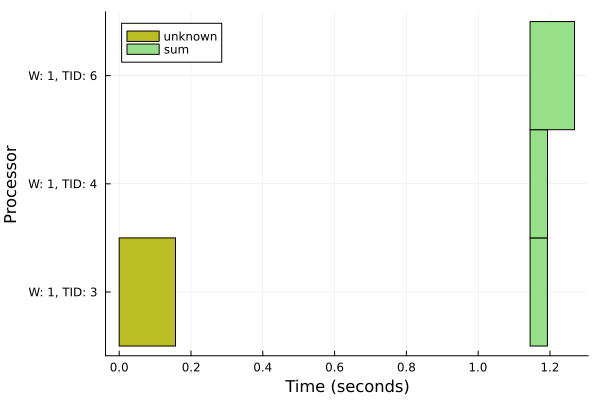

Execution Gantt chart:


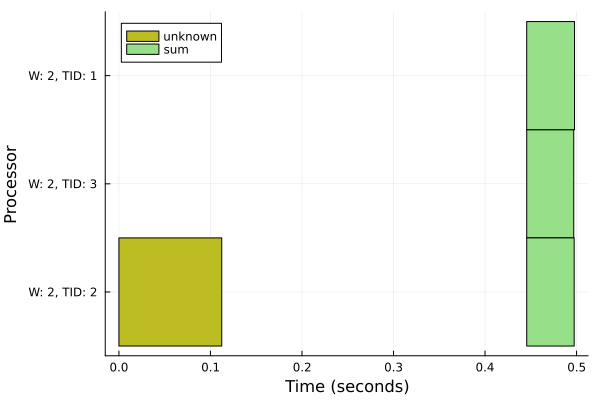

In [2]:
A = Dagger.@spawn scope=Dagger.scope(worker=1) rand(4096, 4096) # So big, wow
workshop_plots(; dag=false) do # Let's see the Gantt chart only
    @sync for i in 1:3
        Dagger.@spawn sum(A)
    end
end

B = Dagger.@spawn scope=Dagger.scope(worker=2) rand(4096, 4096) # So big, so far, wow wow
workshop_plots(; dag=false) do
    @sync for i in 1:3
        Dagger.@spawn sum(B)
    end
end

#### Example 2: Dynamic Scaling

Let's pause again real quick to see how Dagger can seamlessly scale to multiple threads or workers with the same code.

#### Gotta Go Fast - GPUs!

No modern Julia workshop would be considered well-rounded without at least discussing GPU support! In the case of Dagger, we'll do a bit more than that - we'll take a look at how to actually use the GPUs you have with Dagger, and how arbitrary code that uses Dagger can suddenly be "transformed" into GPU-aware code! To start with, how do GPUs and Dagger mesh?

In Dagger, a GPU is just another device that can run code, just like CPUs. It might expect data to be in a certain format, and we might have some restrictions on what code can be run, but to Dagger, these don't matter too much. From Dagger's perspective, you give it a function and arguments to call; then, Dagger's scheduler picks a processor to run on (this could be either a CPU or GPU); finally, if necessary, Dagger "moves" your function and arguments to be compatible with the processor that its scheduler chose, and then Dagger just calls the function and arguments.

Let's be a bit more specific - if you give Dagger a call like `Dagger.@spawn sum(A)`, where `A` is just an `Array`, then it's super obvious what to do if the scheduler picks the CPU for execution - call everything as-is! But what if the scheduler picks a GPU? Well, it's not really that complicated - you just convert `A` to be a GPU array (say, a `CuArray` for CUDA, a `ROCArray` for ROCm, etc.), and then pass that new GPU-ified array to `sum`. The difference between using and not using Dagger for this, is that Dagger will do that conversion for you. No need to manually convert arguments to GPU arrays, Dagger will do this whenever it's necessary.

Ok ok, enough talk, what does this actually look like? We'll see this momentarily, but first, let's setup our GPU support packages.

#### GPU setup

To use GPUs in Dagger, we just need to load our vendor-specific backend (CUDA.jl, AMDGPU.jl, Metal.jl, or oneAPI.jl), and the DaggerGPU.jl support package, which includes all the logic that Dagger uses to work with GPUs. If you want to run this section of the workshop, then run the cell to load DaggerGPU.jl, and then run only the cell that matches the GPU you have on your laptop (or wherever you're running this notebook):

**Important Note** If you don't have a GPU, or don't want to use it, just skip executing this section! Still, you should follow along with the examples to understand how this all works.

In [17]:
# All GPU users - run this!
using DaggerGPU

# Annoying, but we need to restart the scheduler for the below changes to take effect...
# Will be fixed in future versions of Dagger!
Dagger.cancel!(;halt_sch=true)

# And we'll setup some defaults, just in case you don't have a GPU, but want to run the examples
GPUArray = Array
scope = Dagger.scope(;worker=1, threads=:)

ProcessScope: worker == 1

In [ ]:
# NVIDIA GPU users - run this!
using CUDA

# Make sure that we have at least one GPU
@assert length(CUDA.devices()) > 0 "You don't have any NVIDIA GPUs!"

# Pick the first available GPU
GPUArray = CuArray
scope = Dagger.scope(;cuda_gpu=1)

In [18]:
# AMD GPU users - run this!
using AMDGPU

# Make sure that we have at least one GPU
@assert length(AMDGPU.devices()) > 0 "You don't have any AMD GPUs!"

# Pick the first available GPU
GPUArray = ROCArray
scope = Dagger.scope(;rocm_gpu=1)

┌ Warning: rocSPARSE is unavailable, functionality will be disabled.
└ @ AMDGPU ~/.julia/packages/AMDGPU/WqMSe/src/AMDGPU.jl:216
┌ Warning: rocALUTION is unavailable, functionality will be disabled.
└ @ AMDGPU ~/.julia/packages/AMDGPU/WqMSe/src/AMDGPU.jl:216
┌ Warning: rocFFT is unavailable, functionality will be disabled.
└ @ AMDGPU ~/.julia/packages/AMDGPU/WqMSe/src/AMDGPU.jl:216
┌ Warning: MIOpen is unavailable, functionality will be disabled.
└ @ AMDGPU ~/.julia/packages/AMDGPU/WqMSe/src/AMDGPU.jl:216


      From worker 3:	┌ Warning: rocSPARSE is unavailable, functionality will be disabled.
      From worker 3:	└ @ AMDGPU ~/.julia/packages/AMDGPU/WqMSe/src/AMDGPU.jl:216
      From worker 3:	┌ Warning: rocALUTION is unavailable, functionality will be disabled.
      From worker 3:	└ @ AMDGPU ~/.julia/packages/AMDGPU/WqMSe/src/AMDGPU.jl:216
      From worker 3:	┌ Warning: rocFFT is unavailable, functionality will be disabled.
      From worker 3:	└ @ AMDGPU ~/.julia/packages/AMDGPU/WqMSe/src/AMDGPU.jl:216
      From worker 3:	┌ Warning: MIOpen is unavailable, functionality will be disabled.
      From worker 3:	└ @ AMDGPU ~/.julia/packages/AMDGPU/WqMSe/src/AMDGPU.jl:216
      From worker 2:	┌ Warning: rocSPARSE is unavailable, functionality will be disabled.
      From worker 2:	└ @ AMDGPU ~/.julia/packages/AMDGPU/WqMSe/src/AMDGPU.jl:216
      From worker 2:	┌ Warning: rocALUTION is unavailable, functionality will be disabled.
      From worker 2:	└ @ AMDGPU ~/.julia/packages/AMDGPU/Wq

UnionScope:
  ExactScope: processor == ROCArrayDeviceProc(worker 1, device 1)

In [ ]:
# Apple GPU users - run this!
using Metal

# Make sure that we have at least one GPU
@assert length(Metal.devices()) > 0 "You don't have any Apple GPUs!"

# Pick the first available GPU
GPUArray = MtlArray
scope = Dagger.scope(;metal_gpu=1)

In [ ]:
# Intel GPU users - run this!
using oneAPI

# Make sure that we have at least one GPU
@assert length(oneAPI.devices()) > 0 "You don't have any Intel GPUs!"

# Pick the first available GPU
GPUArray = oneArray
scope = Dagger.scope(;intel_gpu=1)

Okay, now that we have our GPU support packages loaded, let's take a look at that `sum(A)` example above. This is going to actually be pretty boring, because so much is happening behind the scenes for us, so we'll turn on some debug statements so that we can get an idea of what's happening:

In [19]:
# Turn on some debug statements
ENV["JULIA_DEBUG"] = "Dagger"
empty!(Dagger.DAGDEBUG_CATEGORIES)
append!(Dagger.DAGDEBUG_CATEGORIES, [:move, :execute])

# Run our `sum` function on the GPU!
A = rand(Float32, 1024)
Dagger.with_options(;scope) do
    @show fetch(Dagger.@spawn sum(A))
end

# Turn off debug statements
ENV["JULIA_DEBUG"] = "";

┌ Debug: [86] (:execute) Moving data
└ @ Dagger ~/.julia/packages/Dagger/crCxz/src/sch/Sch.jl:1544
┌ Debug: [86] (:move) Moved argument 0 to Dagger.ThreadProc(1, 1): Dagger.Chunk{typeof(Dagger.Sch.eager_thunk), MemPool.DRef, OSProc, ExactScope} -> typeof(Dagger.Sch.eager_thunk)
└ @ Dagger ~/.julia/packages/Dagger/crCxz/src/sch/Sch.jl:1602
┌ Debug: [86] (:execute) Executing typeof(Dagger.Sch.eager_thunk)
└ @ Dagger ~/.julia/packages/Dagger/crCxz/src/sch/Sch.jl:1646
┌ Debug: [87] (:execute) Moving data
└ @ Dagger ~/.julia/packages/Dagger/crCxz/src/sch/Sch.jl:1544
┌ Debug: [87] (:move) Moved argument 0 to ROCArrayDeviceProc(worker 1, device 1): Dagger.Chunk{typeof(sum), MemPool.DRef, OSProc, UnionScope} -> typeof(sum)
└ @ Dagger ~/.julia/packages/Dagger/crCxz/src/sch/Sch.jl:1602
┌ Debug: [87] (:move) Moved argument 1 to ROCArrayDeviceProc(worker 1, device 1): Vector{Float32} -> ROCArray{Float32, 1, AMDGPU.Runtime.Mem.HIPBuffer}
└ @ Dagger ~/.julia/packages/Dagger/crCxz/src/sch/Sch.jl:1602

fetch(#= In[19]:9 =# Dagger.@spawn(sum(A))) = 506.01004f0


...wait, that's it? Yep! Using GPUs in Dagger is basically super boring - you turn them on, and then things use the GPU. There are no special APIs, no dealing with GPU synchronization, data movement, pointers, any of that madness.

Alright, let's be realistic for a second though - not every `Dagger.@spawn` is GPU-compatible. If you call a GPU-incompatible function, Dagger can't fix that for you - it will still error or blow up in fun ways. Dagger's GPU support has a key assumption baked in - once Dagger converts your arguments to be GPU-compatible, a Julia method must exist that's prepared to deal with GPU arguments, or else you'll get an error.

Ok, but what if we want to *make* some code GPU-compatible? Just like without Dagger, there are generally two good options:
- Use GPU-aware array operations (like BLAS, broadcast, mapreduce, etc.)
- Write a kernel (with KernelAbstractions)

When using Dagger, either option is valid! A chain of GPU-enabled array operations works as you'd expect:

In [20]:
A = rand(Float32, 1024, 1024)
D = Dagger.with_options(;scope) do
    B = Dagger.@spawn A .* 2
    C = Dagger.@spawn A * B
    Dagger.@spawn transpose(C)
end
fetch(D)

1024×1024 transpose(::Matrix{Float32}) with eltype Float32:
 522.501  501.307  521.869  527.164  …  504.271  519.137  528.174  519.52
 505.778  472.616  515.148  494.67      487.919  513.132  509.143  504.799
 526.552  502.135  533.525  508.369     503.265  503.32   520.49   528.231
 541.953  506.27   541.039  522.266     508.503  524.49   546.536  528.157
 525.633  510.56   548.005  525.714     510.868  533.784  531.882  530.761
 520.026  491.583  537.72   520.837  …  503.406  516.896  526.646  519.606
 522.472  488.497  520.022  510.176     497.287  514.654  520.158  520.125
 509.033  472.289  516.354  506.314     489.815  500.898  509.562  513.094
 507.873  483.711  529.155  504.398     492.732  507.362  512.02   509.718
 523.651  500.563  532.784  518.752     515.295  523.249  516.307  514.715
 513.665  483.644  526.788  516.044  …  491.994  522.004  517.715  513.917
 511.276  491.928  520.88   512.243     497.495  501.456  505.653  510.108
 505.279  472.913  495.857  491.125     4

And what if we want to write a GPU kernel? We can define a KernelAbstractions kernel as normal:

In [21]:
using KernelAbstractions

@kernel function estimate_pi(samples)
    idx = @index(Global, Linear)
    num_samples = length(samples)

    inside_circle = 0

    for _ in 1:num_samples
        x = rand()
        y = rand()
        if x^2 + y^2 <= 1.0
            inside_circle += 1
        end
    end

    samples[idx] = 4 * (Float32(inside_circle) / num_samples)
end

estimate_pi (generic function with 4 methods)

Then we can use DaggerGPU's `Kernel` wrapper to launch the kernel on whatever GPU we've selected:

In [ ]:
import DaggerGPU: Kernel

samples = GPUArray(zeros(Float32, 1024))
Dagger.with_options(;scope) do
    wait(Dagger.@spawn Kernel(estimate_pi)(samples; ndrange=length(samples)))
end
samples

You might be wondering, why have the `GPUArray` call here? Dagger automatically copies arguments to/from the GPU, but only when arguments flow from input argument, through the function, to the function's result, which can then re-enter this cycle as an input argument to another task. However, our kernel doesn't return any arrays, but instead writes into its `samples` argument directly. Since Dagger isn't aware of this, it wouldn't know that the data needs to be copied back (from the GPU copy of `samples` it made to the original `samples` array we allocate above with `zeros`), so you wouldn't see the correct result when you look at `samples` at the end.

What we're doing by moving `samples` to the GPU is ensuring that Dagger doesn't need to make any copies of `samples`, so that it will use the same `samples` object that we allocated. This is annoying to have to do, but Dagger has a solution to this called "Datadeps" that we'll introduce in later sections.

#### Multiple Kernels and Synchronization

If you want to launch more than one kernel, you can do so:

In [16]:
samples = [GPUArray(zeros(Float32, 1024)) for _ in 1:4]
@sync Dagger.with_options(;scope) do
    Dagger.@spawn Kernel(estimate_pi)(samples[1]; ndrange=length(samples[1]))
    Dagger.@spawn Kernel(estimate_pi)(samples[2]; ndrange=length(samples[2]))
    Dagger.@spawn Kernel(estimate_pi)(samples[3]; ndrange=length(samples[3]))
    Dagger.@spawn Kernel(estimate_pi)(samples[4]; ndrange=length(samples[4]))
end
samples[2]

1024-element ROCArray{Float32, 1, AMDGPU.Runtime.Mem.HIPBuffer}:
 3.1484375
 3.0976562
 3.21875
 3.1210938
 3.171875
 3.15625
 3.1679688
 3.1210938
 3.15625
 3.1015625
 3.1875
 3.1289062
 3.1328125
 ⋮
 3.046875
 3.1484375
 3.1914062
 3.1367188
 3.1132812
 3.2226562
 3.109375
 3.1523438
 3.2539062
 3.171875
 3.125
 3.1640625

And if you want to launch a kernel that needs to wait on a previously-launched kernel (say, because they access the same array), you can use Dagger's `spawn_sequential` region to order task launches:

In [18]:
using Statistics

samples = GPUArray(rand(Float32, 1024))
fetch(Dagger.with_options(;scope) do
    Dagger.spawn_sequential() do # All launched tasks within will execute one-after-another
        Dagger.@spawn Kernel(estimate_pi)(samples; ndrange=length(samples))
        Dagger.@spawn mean(samples)
    end
end)

3.141243f0

#### End of Task Section

Okay, that's enough about tasks! What we've learned so far is:
- How to launch, wait on, fetch from, and chain, Dagger tasks (`DTask`s)
- How to control task execution with scopes
- How Dagger's scheduler picks where to run tasks, and how data is moved automatically
- How to use GPUs from Dagger, and how to synchronize GPU kernel launches appropriately

Let's now move on to a higher-level abstraction that everyone is familiar with: Arrays!

# Array Programming with Dagger

Arrays are super useful! Julia uses them all throughout its codebase, and nearly every Julia package uses them heavily. They are simple, storage-efficient, and have a huge range of available functionality. You can build anything with the right set of arrays and algorithms that use them.

All of that said, parallel array operations are not really first-class in Julia - operations like `sum`, `reduce`, broadcasting, and much more, don't use multithreading at all, even if you have a bunch of CPUs and have started Julia with multiple threads. While this may eventually change in future versions of Julia, it will probably only happen for a handful of array operations at a time, and won't just magically apply to the operations that your code uses.

#### Dagger's `DArray`

Thankfully, Dagger has its own array type, the `DArray`, which is inherently parallel for basically all operations:

sum(DA) = 523751.87540477776
Task DAG:


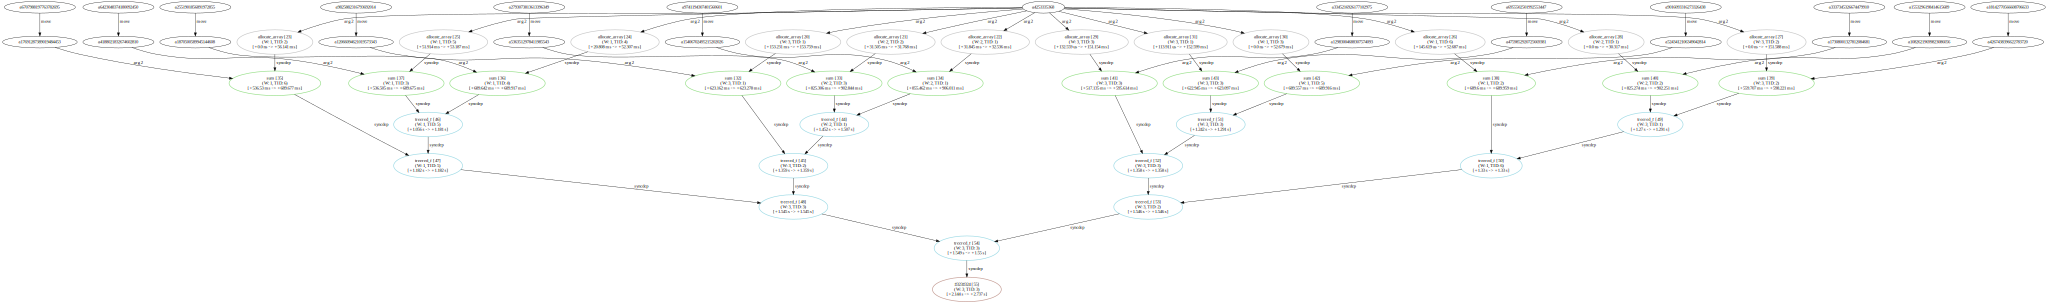

Execution Gantt chart:


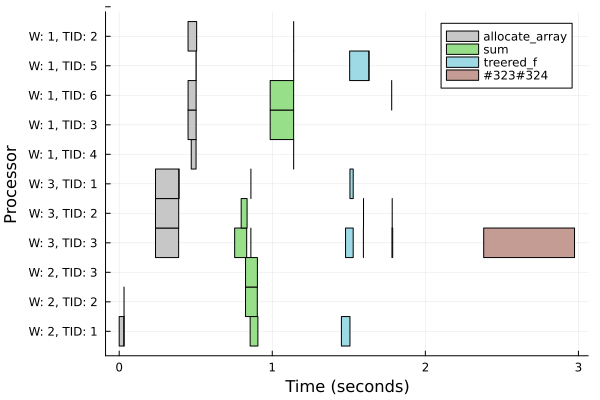

In [4]:
DA = workshop_plots() do
    # Create a random distributed array with chunks of size 1024 x 1024
    DA = rand(AutoBlocks(), 1024, 1024)

    # Do a distributed and multithreaded sum
    @show sum(DA)
    DA
end

@assert sum(collect(DA)) ≈ sum(DA)

Not bad! Performance isn't perfect, but it's not too bad for an automatically distributed and multithreaded operation (which is generically implemented, and will have similar performance for all kinds of reductions). This performance will improve over time as Dagger itself improves.

You can see that just like Dagger tasks, the `DArray` is lazy. `fetch` can be used to ensure that operations are completed, and `collect` is used to convert a `DArray` into a regular Julia `Array`.

The `DArray` supports a variety of array operations just like Julia's `Array`s:

In [5]:
# Create a local array (not distributeed)
A = rand(64, 64)

# Let's distribute A across our workers by partitioning in 16 x 16 blocks
DA = DArray(A)
# This is also equivalent to:
# DA = DArray(A, AutoBlocks())
# ...which automatically picks a partitioning scheme for you!

# Do a map operation on it:
DB = fetch(map(x->x*2, DA))

64x64 DMatrix{Float64} with 1x11 partitions (each of size 64x6):
 1.8659     0.118748  1.08275   0.146086   …  1.93046    0.0347002  1.29241
 1.74304    0.855658  1.17607   0.0239814     0.173115   1.87701    1.11972
 0.0997082  0.315306  0.498456  0.767597      1.03353    0.135454   1.07191
 1.09844    1.78456   0.312321  1.20858       1.6536     1.45003    1.47383
 1.04347    1.75364   1.84542   1.93231       0.836012   0.410083   1.19348
 1.19727    1.12997   0.181611  1.99458    …  1.92       1.88535    0.56315
 0.188159   1.19207   0.545058  0.671505      1.88251    0.0548676  1.08912
 1.43874    0.535012  0.675515  1.54883       1.48406    1.6097     1.00916
 1.76937    0.950464  1.12701   0.479492      0.352054   0.213821   0.497546
 0.792177   1.94327   0.701074  1.33498       1.78973    1.49023    0.542647
 0.846536   0.779815  0.187374  0.632613   …  0.0733191  0.14549    1.04628
 0.752396   1.7412    0.63733   1.13729       1.45804    1.47236    1.15541
 1.46565    0.905212 

Complex operations like broadcasting work too:

In [6]:
fetch(DA .* 2 .+ DB)

64x64 DMatrix{Float64} with 1x11 partitions (each of size 64x6):
 3.73179   0.237496  2.1655    0.292173   …  3.86091   0.0694003  2.58482
 3.48608   1.71132   2.35214   0.0479629     0.346231  3.75402    2.23945
 0.199416  0.630612  0.996912  1.53519       2.06705   0.270909   2.14382
 2.19687   3.56913   0.624641  2.41716       3.30719   2.90006    2.94767
 2.08694   3.50729   3.69084   3.86462       1.67202   0.820165   2.38695
 2.39454   2.25994   0.363222  3.98916    …  3.84      3.7707     1.1263
 0.376319  2.38413   1.09012   1.34301       3.76501   0.109735   2.17824
 2.87748   1.07002   1.35103   3.09766       2.96811   3.21941    2.01832
 3.53874   1.90093   2.25402   0.958985      0.704109  0.427642   0.995092
 1.58435   3.88655   1.40215   2.66996       3.57946   2.98046    1.08529
 1.69307   1.55963   0.374748  1.26523    …  0.146638  0.29098    2.09256
 1.50479   3.48241   1.27466   2.27459       2.91608   2.94471    2.31082
 2.9313    1.81042   1.47244   2.89356       0.

Ok, but where's the proof that this is actually distributed or multithreaded? Well, we can easily see which workers and threads this `map` call is operating on:

In [7]:
DC = rand(Blocks(4, 4), 16, 16)

# Which worker is running our tasks?
fetch(map(x->Distributed.myid(), DC))

16x16 DMatrix{Int64} with 4x4 partitions (each of size 4x4):
 1  1  1  1  2  2  2  2  1  1  1  1  1  1  1  1
 1  1  1  1  2  2  2  2  1  1  1  1  1  1  1  1
 1  1  1  1  2  2  2  2  1  1  1  1  1  1  1  1
 1  1  1  1  2  2  2  2  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  3  3  3  3  1  1  1  1
 1  1  1  1  1  1  1  1  3  3  3  3  1  1  1  1
 1  1  1  1  1  1  1  1  3  3  3  3  1  1  1  1
 1  1  1  1  1  1  1  1  3  3  3  3  1  1  1  1
 2  2  2  2  2  2  2  2  1  1  1  1  3  3  3  3
 2  2  2  2  2  2  2  2  1  1  1  1  3  3  3  3
 2  2  2  2  2  2  2  2  1  1  1  1  3  3  3  3
 2  2  2  2  2  2  2  2  1  1  1  1  3  3  3  3
 2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3
 2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3
 2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3
 2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3

In [8]:
# And which threads are running our tasks?
fetch(map(x->Threads.threadid(), DC))

16x16 DMatrix{Int64} with 4x4 partitions (each of size 4x4):
 2  2  2  2  2  2  2  2  5  5  5  5  6  6  6  6
 2  2  2  2  2  2  2  2  5  5  5  5  6  6  6  6
 2  2  2  2  2  2  2  2  5  5  5  5  6  6  6  6
 2  2  2  2  2  2  2  2  5  5  5  5  6  6  6  6
 5  5  5  5  2  2  2  2  3  3  3  3  4  4  4  4
 5  5  5  5  2  2  2  2  3  3  3  3  4  4  4  4
 5  5  5  5  2  2  2  2  3  3  3  3  4  4  4  4
 5  5  5  5  2  2  2  2  3  3  3  3  4  4  4  4
 2  2  2  2  3  3  3  3  4  4  4  4  1  1  1  1
 2  2  2  2  3  3  3  3  4  4  4  4  1  1  1  1
 2  2  2  2  3  3  3  3  4  4  4  4  1  1  1  1
 2  2  2  2  3  3  3  3  4  4  4  4  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  3  3  3  3
 1  1  1  1  1  1  1  1  1  1  1  1  3  3  3  3
 1  1  1  1  1  1  1  1  1  1  1  1  3  3  3  3
 1  1  1  1  1  1  1  1  1  1  1  1  3  3  3  3

You might be wondering, how does the `DArray` work? Is it a magical built-in? Well, it's really just a generic container around Dagger tasks, which is easy enough to see for yourself:

In [9]:
chunks(DC)

4×4 Matrix{Any}:
 DTask (finished)  DTask (finished)  DTask (finished)  DTask (finished)
 DTask (finished)  DTask (finished)  DTask (finished)  DTask (finished)
 DTask (finished)  DTask (finished)  DTask (finished)  DTask (finished)
 DTask (finished)  DTask (finished)  DTask (finished)  DTask (finished)

Since this array is 16 x 16 total elements and partitioned into chunks of 4 x 4, we thus have 4 x 4 `DTask`s, one for each chunk of the partitioned array. You can check the value of any of these chunks by `fetch`ing them, as you'd expect:

In [10]:
fetch(chunks(DC)[3,4])

4×4 Matrix{Float64}:
 0.883922  0.956472  0.568708   0.386413
 0.79012   0.725496  0.0246787  0.403241
 0.647958  0.191854  0.521732   0.894847
 0.928018  0.104897  0.912662   0.706879

Operations on the `DArray` simply take these tasks as input, passing them into other Dagger tasks, and putting the resulting tasks into a new `DArray` that's returned to you. All of the computations and data movement happen in Dagger in the background.

While most operations on the `DArray` are parallel, they also support regular indexing just fine, so arbitrary operations (which don't know about the `DArray`) can still work:

In [11]:
total = 0.0
for i in 1:length(DC)
    total += DC[i]
end
total ≈ sum(DC)

true

Do beware, though, that indexing is sequential and so quite slow right now - try to avoid it and instead use operations like `map`, `reduce`, broadcasting or other operations which operate on the full array, instead of accessing individual elements.

`DArray`s also support in-place modification, either via indexing or broadcast:

In [12]:
DC[2,2] = 0.0
DC[3:4,3:4] .= 100.0
DC

16x16 DMatrix{Float64} with 4x4 partitions (each of size 4x4):
 0.154363  0.622522     0.223872   …  0.658099   0.425207    0.297558
 0.135983  0.0          0.612377      0.239581   0.727894    0.0379868
 0.321336  0.513602   100.0           0.72963    0.261799    0.696389
 0.992942  0.860009   100.0           0.496531   0.955624    0.147893
 0.807273  0.647326     0.201404      0.790962   0.846108    0.778698
 0.964987  0.423612     0.618103   …  0.0251336  0.86833     0.705656
 0.683159  0.851692     0.284425      0.641501   0.678203    0.99907
 0.481432  0.496289     0.630353      0.851527   0.435073    0.649381
 0.49824   0.0495471    0.706331      0.956472   0.568708    0.386413
 0.123086  0.468963     0.646428      0.725496   0.0246787   0.403241
 0.263242  0.140173     0.827065   …  0.191854   0.521732    0.894847
 0.889949  0.0297196    0.243812      0.104897   0.912662    0.706879
 0.177832  0.537692     0.850381      0.533899   0.84604     0.348392
 0.801378  0.553883     0.0

Again, `DC[2,2] = 0.0` will be relatively slower per element versus `DC[3:4,3:4] .= 100.0`, because Dagger can't parallelize the individual operations (and they have more overhead per element).

Related to in-place operation, you can also wrap a regular `Array` with a `DArray` very cheaply, and it will reflect any changes to either:

In [13]:
V = rand(8, 8)
DV = view(V, Blocks(4, 4))
DV[2,2] = 3.0
V[3,3] = 4.0
DV

8x8 DMatrix{Float64} with 2x2 partitions (each of size 4x4):
 0.74662    0.59135   0.687855   0.0811941  …  0.926844  0.389411  0.2663
 0.740539   3.0       0.0847753  0.608609      0.881992  0.585106  0.109319
 0.393911   0.593763  4.0        0.0502245     0.932977  0.65766   0.995535
 0.830083   0.818664  0.0908396  0.763294      0.595619  0.569154  0.118609
 0.38396    0.875521  0.790595   0.462683      0.932537  0.507129  0.819932
 0.329444   0.886502  0.529463   0.544924   …  0.851868  0.293277  0.460958
 0.102492   0.470805  0.0941447  0.62941       0.724126  0.544842  0.750455
 0.0735574  0.252327  0.357001   0.832136      0.923108  0.702034  0.860758

#### Linear Algebra Operations

The `DArray` contains a nice built-in collection of parallelized linear algebra operations as well, thanks to Rabab and Felipe, two of our core Dagger contributors. In particular, you can expect many common operations to work nicely:

In [ ]:
using LinearAlgebra

A = rand(AutoBlocks(), 1024, 1024)
B = rand(AutoBlocks(), 1024, 1024)
C = zeros(AutoBlocks(), 1024, 1024)

@info "Matmul:"
workshop_plots(;dag=false) do
    mul!(C, A, B)
end
@show norm(collect(C) - (collect(A) * collect(B)))

#= TODO: D[diagind(D)] is broken, so we need to do this on an underlying Array
D = rand(AutoBlocks(), 1024, 1024)
D = D * D'
D[diagind(D)] .+= size(D, 1)
=#
A = rand(1024, 1024)
A = A * A'
A[diagind(A)] .+= size(A, 1)
D = DArray(A)
@info "Cholesky:"
AcholU = workshop_plots(;dag=false) do
    cholesky(D).U
end
@show norm(AcholU - cholesky(A).U)

#= TODO: PRs are almost done, just finishing up some remaining details!
println("QR:")
workshop_plots() do
    Aq = qr(A)
end

println("LU:")
workshop_plots() do
    Al = lu(A)
end

println("Triangular solve:")
X = rand(AutoBlocks(), 1024)
workshop_plots() do
    Bdiv = A \ X
end
=#

All of the in-place variants of these operations are well-supported, and more are soon to come (particularly the SVD).

#### GPU Array Operations

It's important to note that the operations that you just saw also (usually) work just fine on GPUs as well. In particular, any algorithms implemented on top of `mapreduce`, broadcast, Datadeps, or common linear algebra operations will all be GPU-capable. Just to confirm:

In [ ]:
Dagger.with_options(;scope) do
    # Allocated directly on the GPU
    DA = rand(AutoBlocks(), Float32, 64, 64)

    # Broadcast is GPU-compatible
    DB = DA .* 3f0

    # Matmul is no problem!
    DC = DB * DB'

    # Finally, any map-reduce algorithm is easy enough
    sum(DC; dims=1)
end

#### Onwards to Datadeps!

But how are these kinds of array operations implemented? Surely Dagger has some nice way for users and libraries to implement parallel operations?

# Dagger's Data Dependencies (Datadeps) System

How does one actually write fast, parallel algorithms with Dagger? C++ converts might be aware of OpenMP, particularly its "task dependencies" feature. This OpenMP feature is basically built on a set of parallel operations (just like Dagger `DTask`s), but where each operation can declare which of its arguments it writes into (such as how `mul!(C, A, B)` writes into `C`). OpenMP uses this information to gently limit parallelism to ensure that parallel operations execute in the right order. This approach is really nice, because it provides a really easy way to convert an in-place, sequentially-specified program into a parallel program, with very minimal changes to how each operation is invoked (but not requiring changes to the operations themselves).

As an example, this is how you'd write a Cholesky factorization in OpenMP's task dependency syntax:

```C
void cholesky_blocked(const int ts, const int nt, double** Ah)
{
    int i, j, k;
    for (k = 0; k < nt; k++) {
        // Diagonal Block factorization and panel permutations

        #pragma omp task depend(inout:Ah[k*nt + k])
          {omp_potrf(Ah[k*nt + k], ts, ts);}

        // Triangular systems

        for (i = k + 1; i < nt; i++) {
            #pragma omp task depend(in:Ah[k*nt + k]) depend(inout:Ah[k*nt + i])
              {omp_trsm(Ah[k*nt + k], Ah[k*nt + i], ts, ts);}
        }

        // update trailing matrix
        for (i = k + 1; i < nt; i++) {
            for (j = k + 1; j < i; j++) {
                #pragma omp task depend(in:Ah[k*nt + i], Ah[k*nt + j]) depend(inout:Ah[j*nt + i])
                  {omp_gemm(Ah[k*nt + i], Ah[k*nt + j], Ah[j*nt + i], ts, ts);}
            }

            #pragma omp task depend(in:Ah[k*nt + i]) depend(inout:Ah[i*nt + i])
              {omp_syrk (Ah[k*nt + i], Ah[i*nt + i], ts, ts);}
        }
    }
}
```

Because we liked this approach to parallelising algorithms so much, we decided to adopt a similar model that we call "Datadeps" (short for "Data dependencies"), which works in much the same way. However, we also added in a lot of additional features and capabilities that OpenMP doesn't have, that we'll soon see.

To understand how Datadeps works, we'll start with a simple example of a parallel vector sum of a regular Julia `Array`.

#### Vector Sum

We use `view` to wrap a `DArray` around `A`, so that we can more easily work with partitions of `A`:

In [45]:
A = rand(1_000_000)
DA = view(A, AutoBlocks())

1000000-element DVector{Float64} with 6 partitions (each of size 166667):
 0.831394
 0.803503
 0.877144
 0.585431
 0.497664
 0.00235176
 0.0817155
 0.810783
 0.773547
 0.710521
 0.791816
 0.96636
 0.635367
 ⋮
 0.675969
 0.172642
 0.0853574
 0.165365
 0.0341185
 0.279092
 0.676512
 0.742963
 0.334706
 0.326242
 0.186344
 0.502157

Now we have a `DVector` DA, and we want to be able to compute its sum efficiently. We can always do `sum(DA)`, but that's cheating!

Let's start by summing each individual array partition:

In [46]:
for part in chunks(DA)
    @show fetch(Dagger.@spawn sum(part))
end

fetch(#= In[46]:2 =# Dagger.@spawn(sum(part))) = 83403.22462855096
fetch(#= In[46]:2 =# Dagger.@spawn(sum(part))) = 83541.8621355562
fetch(#= In[46]:2 =# Dagger.@spawn(sum(part))) = 83412.38027778397
fetch(#= In[46]:2 =# Dagger.@spawn(sum(part))) = 83301.10950344572
fetch(#= In[46]:2 =# Dagger.@spawn(sum(part))) = 83374.96008977477
fetch(#= In[46]:2 =# Dagger.@spawn(sum(part))) = 83371.13027221136


Ok, we can quite easily sum partitions - now let's tie this together, with Datadeps! We need to store our partial sums somewhere, so we'll allocate a temporary array to hold those. We'll then use `spawn_datadeps` to create a Datadeps region, within which we can safely write our partial sums to this temporary array. Finally, we can (still within the Datadeps region) `sum` the temporary array of partial sums to get our total sum:

In [51]:
function datadeps_sum(DA::DVector)
    # Allocate a temporary output `Vector`, with the same number of elements as
    # the number of partitions in `DA`
    nchunks = length(DA.chunks)
    temp = zeros(Float64, nchunks)
    
    # Use `spawn_datadeps` to start a Datadeps region
    return fetch(Dagger.spawn_datadeps() do
        # For each partition of `DA`, sum it and write the result into the
        # corresponding slot of `temp`
        for (idx, part) in enumerate(chunks(DA))
            temp_view = view(temp, idx:idx)
            # Specify to Datadeps that `temp_view` is written to by this task
            Dagger.@spawn sum!(Write(temp_view), part)
        end
    
        # Finally, calculate and return the sum of `temp`, which is the sum of `DA`
        Dagger.@spawn sum(temp)
    end)
end

datadeps_sum (generic function with 2 methods)

You'll notice that we use the `Write` function to wrap a view of our temporary array. What this does is tell Datadeps that `sum!` will mutate all or some of `temp_view`, so it needs to make sure that any operations after `sum!` that reads from or writes to an overlapping memory region wait for `sum!` to finish before proceeding. In this example, the only operation that does this is the final `sum`, so `sum` will wait until all `sum!` calls finish before executing. Noticeably, all of the individual `sum!` calls are independent of each other, and write to different parts of `temp` (through `temp_view`), so Datadeps will parallelize all of those calls. We can see what's handed to Dagger's scheduler by Datadeps:

Task DAG:


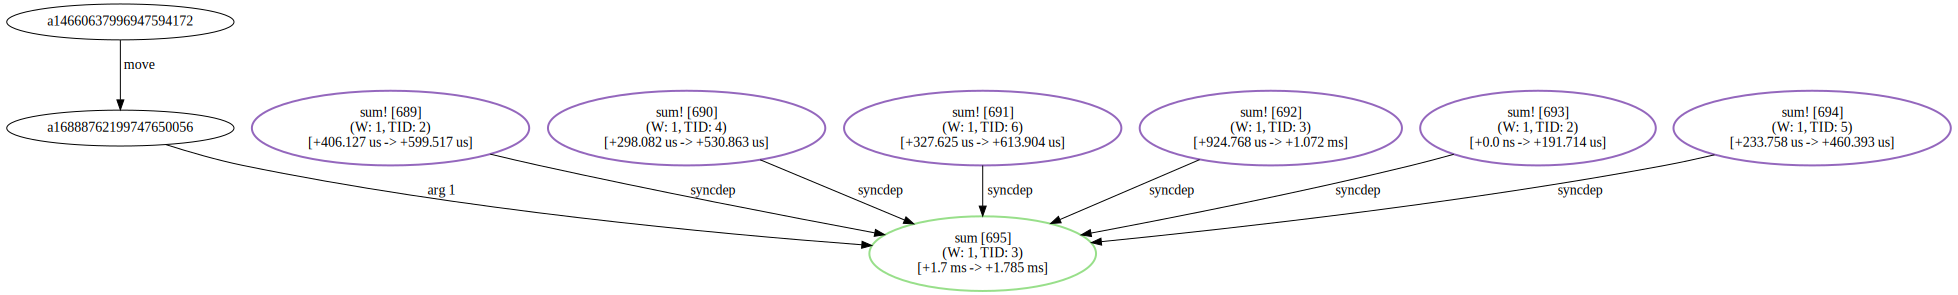

Execution Gantt chart:


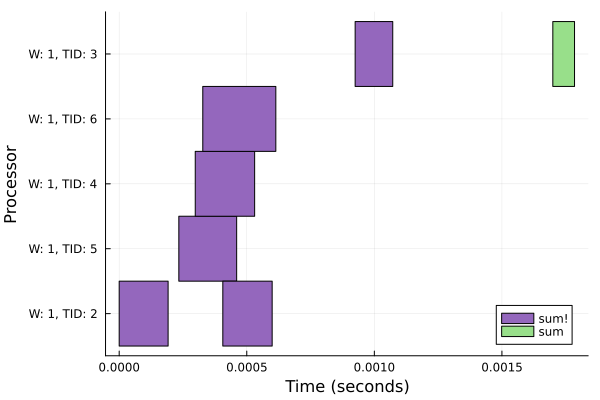

result = 500404.66690732306


In [52]:
# Same result, but more parallel!
result = workshop_plots() do
    datadeps_sum(DA)
end
@show result
@assert result ≈ sum(A)

This example is nice because it's so simple! We can see how Datadeps lets us express in-place operations without imposing a burden of parallelizing the algorithm ourselves. Another useful thing to notice is that we were able to pass a view to `temp`, yet Datadeps was aware that `sum(temp)` would also access overlapping memory, and was able to synchronize accordingly. This is a powerful feature of Datadeps that extends not just to views, but also array wrappers like `Adjoint`, `UpperTriangular`, and more.

Let's take a look at an algorithm which stresses this functionality a bit more: the Convolution. This operation "slides" one array over another, performing a dot product at each position. It's typically very hard to optimize, so we'll just implement a very basic convolution algorithm that works on plain contiguous input and output arrays:

In [ ]:
import Images, ImageFiltering, FileIO
using LinearAlgebra

function conv_inner!(output, input, kernel)
    output[1] = dot(input, kernel)
    return
end
function conv_strip!(output, output_idx, input, kernel)
    output_size = size(parent(output))
    for idx in CartesianIndices(output)
        output_view = view(output, idx:idx)

        real_idx = CartesianIndex(ntuple(i->i == 2 ? output_idx : idx.I[i], ndims(output)))
        input_start = real_idx - CartesianIndex(fld.(size(kernel), 2))
        input_stop = real_idx + CartesianIndex(fld.(size(kernel), 2))

        # Lazy bounds-checking
        any(i->(Tuple(input_start)[i] < 1) || (Tuple(input_start)[i] > output_size[i]), 1:ndims(output)) && continue
        any(i->(Tuple(input_stop)[i] < 1) || (Tuple(input_stop)[i] > output_size[i]), 1:ndims(output)) && continue

        input_view = view(input, input_start:input_stop)
        conv_inner!(output_view, input_view, kernel)
    end
end
function conv!(output, input, kernel)
    @assert size(output) == size(input)
    @assert all(isodd, size(kernel))

    Dagger.spawn_datadeps() do
        for idx in 1:size(output, 2)
            output_view = view(output, 1:size(output, 1), idx:idx)
            Dagger.@spawn conv_strip!(Write(output_view), idx, input, kernel)
        end
    end
end

# Load the Dagger logo
input = map(pix->Float64(pix.r), FileIO.load("logo.jpg"))
output = similar(input)
M, N = size(input)

# Some random kernel I made up
kernel = [1  0  1;
          0  0  0;
          -1  0 1]

@time conv!(output, input, kernel)

@assert output[2:(M-1),2:(N-1)] ≈ ImageFiltering.imfilter(input, kernel)[2:(M-1),2:(N-1)]

println("Input:")
display(Images.Gray.(input))

println("Output:")
Images.Gray.(output)

Above, we chose to "stripe" the output and input arrays along a single dimension; this is done to reduce the number of Dagger tasks that we end up spawning, as each task has some overhead. It is slightly annoying to need to do this, but thankfully some helper utilities for filters and stencil operations are in the works that avoid these issues, and will build on Datadeps naturally.

#### A final Datadeps example: Conway's Game of Life

This example is a little bit more "fun", but also showcases some corner cases you might have to deal with when using datadeps with `DArray`s: Conway's Game of Life, using Dagger! Here we use `DArray`s to store and update states for agents in the simulation, and we plot the results after every simulation step so we can see what's going on. One key thing to notice is that we need to deal with lots of neighboring tiles; this is because Life is effectively a stencil-based algorithm.

What this means is that, to compute a new element at each position, we need to know the current values of all immediately surrounding elements; this is easy when the element in question is an "internal" element, but it gets complicated when working with "border" elements (at the edges of a `DArray` partition). In those cases, we need to have access to all the surrounding tiles when computing any given tile; this also wraps around, at least for this Life implementation (other boundary behaviors are possible).

We're working on implementing a helper macro for stencil operations that will make writing algorithms like Life much easier, by automatically handling these border elements for us. In the meantime, feel free to study the implementation, or just enjoy the results!

In [49]:
function life!(output_tile::Matrix{Bool}, local_tile::Matrix{Bool}, north_tile, south_tile, west_tile, east_tile, northwest_tile, northeast_tile, southwest_tile, southeast_tile)
    function neighbor_value(idx, ns, we)
        @assert ns in (-1, 0, 1)
        @assert we in (-1, 0, 1)
        bounds = size(local_tile)
        adj_idx = idx + CartesianIndex(ns, we)
        if (adj_idx.I[1] < 1) && (adj_idx.I[2] < 1)
            # North-West
            return northwest_tile[bounds[1], bounds[2]]
        elseif (adj_idx.I[1] < 1) && (1 <= adj_idx.I[2] <= bounds[2])
            # North
            return north_tile[bounds[1], adj_idx.I[2]]
        elseif (adj_idx.I[1] < 1) && (adj_idx.I[2] > bounds[2])
            # North-East
            return northeast_tile[bounds[1], 1]
        elseif (1 <= adj_idx.I[1] <= bounds[1]) && (adj_idx.I[2] > bounds[2])
            # East
            return east_tile[adj_idx.I[1], 1]
        elseif (adj_idx.I[1] > bounds[1]) && (adj_idx.I[2] > bounds[2])
            # South-East
            return southeast_tile[1, 1]
        elseif (adj_idx.I[1] > bounds[1]) && (1 <= adj_idx.I[2] <= bounds[2])
            # South
            return south_tile[1, adj_idx.I[2]]
        elseif (adj_idx.I[1] > bounds[1]) && (adj_idx.I[2] < 1)
            # South-West
            return southwest_tile[1, bounds[2]]
        elseif (1 <= adj_idx.I[1] <= bounds[1]) && (adj_idx.I[2] < 1)
            # West
            return west_tile[adj_idx.I[1], bounds[2]]
        else
            # Local
            return local_tile[adj_idx]
        end 
    end
    for idx in CartesianIndices(local_tile)
        this = local_tile[idx]
        north = neighbor_value(idx, 0, -1)
        south = neighbor_value(idx, 0, +1)
        west = neighbor_value(idx, -1, 0)
        east = neighbor_value(idx, +1, 0)
        northwest = neighbor_value(idx, -1, -1)
        northeast = neighbor_value(idx, -1, +1)
        southwest = neighbor_value(idx, +1, -1)
        southeast = neighbor_value(idx, +1, +1)
        neighs = north + south + west + east + northwest + northeast + southwest + southeast
        if this && neighs < 2
            output_tile[idx] = 0
        elseif this && neighs > 3
            output_tile[idx] = 0
        elseif !this && neighs == 3
            output_tile[idx] = 1
        else
            output_tile[idx] = this
        end
    end
end

# Initialize tiles
N = 9
nt = 3
tiles = zeros(Blocks(N, N), Bool, N*nt, N*nt)
outputs = zeros(Blocks(N, N), Bool, N*nt, N*nt)
render_tile = zeros(Bool, N*nt, N*nt)

# Create fun initial state
tiles[13, 14] = 1
tiles[14, 14] = 1
tiles[15, 14] = 1
tiles[14, 13] = 1
@view(tiles[1:N, 1:N]) .= rand(Bool, N, N)

function wrapped(tiles, idx, ns, we)
    adj_idx_tuple = (idx + CartesianIndex(ns, we)).I
    if adj_idx_tuple[1] < 1
        adj_idx_tuple = (nt, adj_idx_tuple[2])
    elseif adj_idx_tuple[1] > nt
        adj_idx_tuple = (1, adj_idx_tuple[2])
    end
    if adj_idx_tuple[2] < 1
        adj_idx_tuple = (adj_idx_tuple[1], nt)
    elseif adj_idx_tuple[2] > nt
        adj_idx_tuple = (adj_idx_tuple[1], 1)
    end
    return tiles[CartesianIndex(adj_idx_tuple)]
end

# Simulate and render
anim = @animate for i in 1:100
    # Render tile state
    copyto!(render_tile, tiles)
    plt = heatmap(render_tile)

    # Update output tiles
    tiles_c = tiles.chunks
    Dagger.spawn_datadeps() do
        for idx in CartesianIndices(tiles_c)
            Dagger.@spawn life!(Write(outputs.chunks[idx]), tiles_c[idx],
                wrapped(tiles_c, idx, -1, 0), # North
                wrapped(tiles_c, idx, +1, 0), # South
                wrapped(tiles_c, idx, 0, -1), # West
                wrapped(tiles_c, idx, 0, +1), # East
                wrapped(tiles_c, idx, -1, -1), # North-West
                wrapped(tiles_c, idx, -1, +1), # North-East
                wrapped(tiles_c, idx, +1, -1), # South-West
                wrapped(tiles_c, idx, +1, +1), # South-East
            )
        end
    end

    # Copy output tiles to main tiles
    copyto!(tiles, outputs)
    fill!(outputs, 0)

    # Display heatmap
    plt
end
mp4(anim; fps=10, show_msg=false)

┌ Warning: skipping callee #lookup_parts#813 (called by lookup_parts) due to AssertionError("ref.mod == moduleof(frame)")
└ @ LoweredCodeUtils ~/.julia/packages/LoweredCodeUtils/608oq/src/signatures.jl:316


Plots.AnimatedGif("/mnt/alpine/home/jpsamaroo/docs/JuliaCon/2024/tmp.mp4")

# Coming Soon

The following features are nearly complete, but were not yet ready enough to be shown during this workshop.

## Dagger Graphs (DGraphs.jl)

Arrays and tables are great when your data fits the more rigid structure that they impose, but sometimes data is just too wildly complex to fit in those formats. Data such as social media graphs, transportation networks, chemical reaction networks, cross-task dependencies, and more, are better represented as a graph - the same structure that Dagger uses internally! Graphs are great when you basically just have a bunch of elements (called "vertices") and relations between them (called "edges"). Conveniently, Dagger has a nearly complete implementation of a graph data structure that leverages Dagger's parallel and distributed nature to handle really big and complicated real-world graphs.

This structure is the `DGraph` - it follows the Graphs.jl interface, yet it's built on partitions made of subgraphs, and can be manually partitioned to best match the graph and/or analyses to be run. It supports all the usual Graphs.jl operations, and will also provide a few useful things of its own:
- First-class metadata and weights support, supporting multiple kinds of (named) metadata and interpreting it as weights
- Parallel-friendly on-disk format and save/load functions, which also supports arbitrary metadata
- Random/directed walk interface for traversing the graph efficiently and in parallel

The DGraph is targeted at all kinds of large graphs, and especially those which benefit from parallel operations, lots of heterogeneous metadata, and data which simply does not effectively fit on a single server.

## Dagger Streaming

Running the same operation again and again, on different data each time, is basically the hallmark of modern parallel programming. Sometimes, you even want to keep running the same operation continuously, without end. Consider an audio filter, which keeps filtering as long as audio keeps coming. Or a payment processing system which will keep handling payments for as long as payments are being made. In situations like these, and many others, you really want infrastructure which is designed to be fast, efficient, reliable, no matter how many items you handle. Normally, this wouldn't be a use case that Dagger would be well-suited to handle (mostly because each task has somewhat high overhead), but there will soon be a feature that makes such use cases possible: Dagger's `spawn_streaming`.

This feature works quite simply: it takes a user-provided function, which launches some `DTask`s, and it automatically "upgrades" them to run continuously. Instead of the tasks each running once on a single set of data, and then finishing, the tasks run continuously, and data is streamed between them automatically. Processing each element is done in a type-stable manner, and allocations should be non-existent or quite minimal per-element. Additionally, support will be available for connecting tasks directly to each other (or other applications/services) over TCP, UDP, MQTT, NATS, and much more, via a programmable stream transfer interface.

All of this functionality will, of course, work across threads, workers, and also eventually also multiple GPUs (if applicable to the program).

# Future Developments

There are quite a few things brewing for future versions of Dagger! Here they are, in no particular order:

## Auto-GPU

It's currently quite annoying that, even though we all know that GPUs support matmuls, we need to use `Dagger.with_options(;scope=Dagger.scope(cuda_gpus=:)) do A * B end` (yuck) to enable GPU execution. There are a lot of common algorithms out there that we can know are implemented for GPUs, so it would be nice if Dagger could recognize that and enable GPUs automatically. Well... that's the plan! We're planning to add a dispatch-based system to allow GPUs to be enabled automatically for supported operations (when the right combination of function and argument types is encountered), so that the next time you do `A * B`, and you have a GPU on your system, Dagger will use it automatically. We'll also teach the scheduler to track the difference in performance when running a task on the CPU vs. GPU, and use that information to decide which GPU-capable tasks should actually use a GPU.

## Datadeps Everywhere!

Datadeps is pretty amazing, if I do say so myself! It's a shame that you need those annoying `spawn_datadeps` calls to make it work, though. What if you could *always* use Datadeps to accelerate code? This is planned for the (hopefully near) future. This would have a lot of benefits:

- Any Dagger task can safely write to their arguments when `ReadWrite`/`Write`/`Deps` are used correctly
- We won't do a costly synchronize and extra copies between operations
- No more need for `spawn_datadeps`!

The model that we plan to implement will look a lot like the synchronization model for the JuliaGPU packages, where every `DTask` launched from the same Julia task will appear to be ordered sequentially, except that Datadeps will run automatically and parallelize any tasks that it can, just as is done today. We'll add in all sorts of caching and optimizations to make things fast and memory efficient.

## Streaming + Datadeps == :heart:

There is a really cool generalization that we can do with many Datadeps algorithms - if you make the size of the input `DArray`'s partitions only contain 1 element each, you can basically run nearly any Datadeps algorithm element-by-element, minimizing memory overhead, allowing for better data latency hiding, and more. Doing this manually right now would work, but isn't very efficient - but with the usage of Dagger's streaming task infrastructure, we could turn any Datadeps-driven operation into a low-latency, low-memory equivalent automatically, if that is requested by the user or deemed profitable by Dagger's scheduler.

## Operator Fusion and other forms of Magic

Matmul is great, Cholesky is nice, but where is my MatmulCholesky operator?! It would be silly to implement all sorts of combinations of operators like this manually, but with the magic of *compilers*, we don't have to! I have plans to add fancy compiler support (through MLIR, XLA, or some other compiler panacea) to Dagger - what would this mean for you? When you do a sequence of operations within this "compiled mode", Dagger would pass the DAG of operations into a compiler, and the compiler would then produce a "merged" operation that combines the functionality of all the operations passed into it, which should overall be faster and more memory efficient than running the operations sequentially and individually.

## Dagger over KernelAbstractions

Sometimes algorithms are best written in SPMD (aka "CUDA" or "ISPC") style, where there are a ton of little threads each working on one element of a collection, and running in near-lockstep with each other. KernelAbstractions.jl (KA) provides a really nice way to express such algorithms, but there's currently no way to use Dagger to parallelize a KA kernel. We're planning to implement a Dagger backend for KernelAbstractions, which will use Dagger (probably through Datadeps) to automatically parallelize workgroups across threads, servers, and multiple GPUs. This would become another great API for accessing the power of Dagger, and would allow even more programs and packages to become automatically Dagger-capable, just by switching to the Dagger backend.

## Dagger and Enzyme

There is no doubt that Automatic Differentiation (AD) has taken the machine learning/AI world by storm, but not everything is peachy; oftentimes it can be difficult to get AD libraries to properly and performantly differentiate arbitrary user code, especially when that code is already parallelized. But when it *does* work, it can enable some really amazing applications, and is increasingly being relied on. Thankfully, Enzyme.jl is quite capable of differentiating all sorts of Julia code, and also has a system for adding support for libraries that provide parallelism abstractions.

We hope to soon add better, regularly tested support for using Enzyme to differentiate Dagger-powered programs. This will especially enable all sorts of ML/AI algorithms to become Dagger-powered, without losing support for AD.

# That's All!

### Thank you for participating!